# Rotation Invariance CNN

## Introduction: 

In this assignment, rotation invariance CNN is investigated.  MNIST datasets are rotated at various angles and shuffled. First, LeNet CNN is used to train and test rotated datasets and accuracy is reported for each rotate angle. Second, the CNN is trained on the original MNIST dataset (e.g. no rotation) and tested on rotated datasets for transfer learning study.  Last, a multi-CNN approach is attempted where image rotation is identified via a CNN and used to revert images to original images before testing on another CNN which has been trained on the original images.

## Results and Discussion:

### Rotation: 
Four MNIST datasets are rotate at 0, 45, 90 and 135 degrees. I couldn't split MNIST datasets consisting 60,000 images so I use four copies.  To avoid aliasing between 6 and 9, these angles are selected. Rotation is performed by transforms.RandomRotation of one angle range (i.e. [45, 45]).
 A sample of rotated images is shown below.

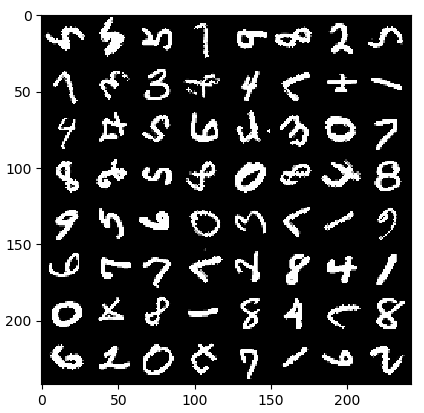

### 1. Trained and tested on rotated datasets:
The accuracy is about 97% for mixed-rotation images (e.g. all rotation angles) and for individual-rotation images (one rotation angle at a time). Even a simple CNN like LeNet is very effective to learn rotated images.

### 2. Trained on original datasets and tested on rotated datasets:
The accuracy is about 45% for mixed-rotation images and 97%-22% for individual-rotation images.  This part can be considered as transfer learning - a CNN trained on original images is used to test rotated images.  I think this performance can be improved if the classifier part (e.g. FCs) is retrained with some rotated images.  

### 3. Multi-CNN:
Two CNNs are used. One CNN is trained on original datasets as a traditional digit classifier.  The other CNN is trained on rotated datasets as a rotation classifier. Each image is fed to the rotation classifier to identify image's rotation angle (i.e.. 75, 25 degrees) which then used to reversely rotate the image to recover the original image before sending to the digit classifier.  The rotation classifier is tested with accuracy 97%. 
Diagram of the process is shown below.

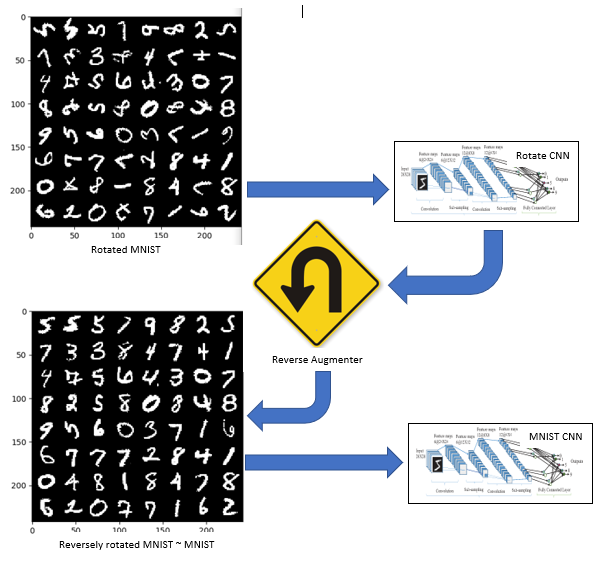

It turns out that that the accuracy attained is about 94% for both mixed-scale images and individual-scale images. This method seems to be similar to human approach: first getting a good view of an image before classifying.  A similar approach is used for rotation, shear and affine images.

## Summary:

In this assignment, we investigated rotation invariant CNN. we found that LeNet can learn rotated images quite well but transfer learning is limited. A multi-CNN approach is attempted with comparable performance as learning on rotated images.  The overall results are shown in table below.

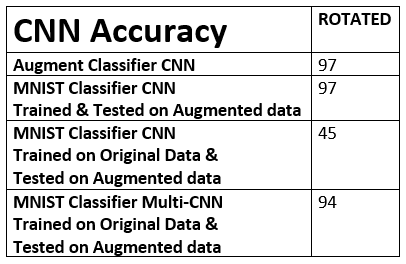

The codes are shown below.

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import ConcatDataset as _ConcatDataset
from torch.utils.data.dataset import Subset
from torchvision import transforms, utils
import sys
import numpy as np

import matplotlib as matplotlib
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # if batch_idx == 0:
        #     print("1st batch train targets and images")
        #     print(target)
        #     grid = utils.make_grid(data)
        #     plt.imshow(grid.numpy().transpose((1, 2, 0)))
            # plt.show()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % args.log_interval == 0:
        #     print(scale)
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))


def test(args, model_digit, model_rotate, device, test_loader, method):
    model_digit.eval()
    model_rotate.eval()
    test_loss = 0
    correct = 0
    if method != 2:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                # if test_loss == 0:
                #     print("1st batch Test targets and images")
                #     print(target[0:64])
                #     grid = utils.make_grid(data[0:64])
                #     plt.imshow(grid.numpy().transpose((1, 2, 0)))
                output_digit = model_digit(data)
                test_loss += F.nll_loss(output_digit, target, reduction='sum').item()  # sum up batch loss
                pred_digit = output_digit.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred_digit.eq(target.view_as(pred_digit)).sum().item()
    else:  # method 2
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                if test_loss == 0:
                    print("1st batch Test targets and images")
                    print(target[0:64])
                    plt.figure(0)
                    grid = utils.make_grid(data[0:64])
                    plt.imshow(grid.numpy().transpose((1, 2, 0)))

                output_rotate = model_rotate(data)
                pred_rotate = output_rotate.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                for i in range(len(data)):
                    predictme = pred_rotate[i][0]
                    revert = -(45 * (predictme - 1))
                    data[i] = data[i] * 0.3081 + 0.1307  # de-normalized
                    data_img = transforms.ToPILImage()(data[i])
                    data[i] = transforms.Compose([
                        transforms.RandomRotation((revert.item(), revert.item())),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])(data_img)

                if test_loss == 0:
                    plt.figure(1)
                    grid = utils.make_grid(data[0:64])
                    plt.imshow(grid.numpy().transpose((1, 2, 0)))

                # predict digit of reverted images using the model_digit trained on original data
                output_digit = model_digit(data)
                test_loss += F.nll_loss(output_digit, target, reduction='sum').item()  # sum up batch loss
                pred_digit = output_digit.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred_digit.eq(target.view_as(pred_digit)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def load_train_data(args, kwargs, traintype):
    d1 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    d2 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.RandomRotation((45, 45)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))

    d3 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.RandomRotation((90, 90)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    d4 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.RandomRotation((135, 135)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    if traintype == 1:
        d1.train_labels[:] = 1  # rotating 0 degrees
        for i in range(list(d2.train_labels.size())[0]):
            if d2.train_labels[i] == 0:  # except digit 0
                d2.train_labels[i] = 1  # rotating 0 degrees
            else:
                d2.train_labels[i] = 2  # rotating 45 degrees
        for i in range(list(d3.train_labels.size())[0]):
            if d3.train_labels[i] == 0:
                d3.train_labels[i] = 1  # rotating 0 degrees
            else:
                d3.train_labels[i] = 3  # rotating 90 degrees
        for i in range(list(d4.train_labels.size())[0]):
            if d4.train_labels[i] == 0:
                d4.train_labels[i] = 1  # rotating 0 degrees
            else:
                d4.train_labels[i] = 4  # rotating 135 degrees

    Comb_data = _ConcatDataset([d1, d2, d3, d4])
    train_loader1 = torch.utils.data.DataLoader(
        d1, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loaderA = torch.utils.data.DataLoader(
        Comb_data, batch_size=args.batch_size, shuffle=True, **kwargs)
    return train_loader1, train_loaderA


def load_test_data(args, kwargs, testtype):
    t1 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
    t2 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.RandomRotation((45, 45)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
    t3 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.RandomRotation((90, 90)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
    t4 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.RandomRotation((135, 135)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

    # only used to evaluate SCALE CLASSIFIER CNN
    if testtype == 1:
        t1.test_labels[:] = 1  # rotating 0 degrees
        for i in range(list(t2.test_labels.size())[0]):
            if t2.test_labels[i] == 0:  # except digit 0
                t2.test_labels[i] = 1  # rotating 0 degrees
            else:
                t2.test_labels[i] = 2  # rotating 45 degrees
        for i in range(list(t3.test_labels.size())[0]):
            if t3.test_labels[i] == 0:
                t3.test_labels[i] = 1  # rotating 0 degrees
            else:
                t3.test_labels[i] = 3  # rotating 90 degrees
        for i in range(list(t4.test_labels.size())[0]):
            if t4.test_labels[i] == 0:
                t4.test_labels[i] = 1  # rotating 0 degrees
            else:
                t4.test_labels[i] = 4  # rotating 135 degrees

    comb_test = _ConcatDataset([t1, t2, t3, t4])
    test_loaderA = torch.utils.data.DataLoader(
        comb_test, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader1 = torch.utils.data.DataLoader(
        t1, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader2 = torch.utils.data.DataLoader(
        t2, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader3 = torch.utils.data.DataLoader(
        t3, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader4 = torch.utils.data.DataLoader(
        t4, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    return (test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4)


def runit(args, device, train_loader_rotate, train_loader_digit, test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4, method):
    model_digit = Net().to(device)
    model_rotate = Net().to(device)
    print(model_digit)
    optimizer_digit = optim.SGD(model_digit.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer_rotate = optim.SGD(model_rotate.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        print("Training ...")
        train(args, model_digit, device, train_loader_digit, optimizer_digit, epoch)
        if method == 2:
            train(args, model_rotate, device, train_loader_rotate, optimizer_rotate, epoch)
        # print("Testing: Rotated angle =  0 degrees")
        # test(args, model_digit, model_rotate, device, test_loader1, method)
        # print("Testing: Rotated angle = 45 degrees")
        # test(args, model_digit, model_rotate, device, test_loader2, method)
        # print("Testing: Rotated angle = 90 degrees")
        # test(args, model_digit, model_rotate, device, test_loader3, method)
        # print("Testing: Rotated angle = 135 degrees")
        # test(args, model_digit, model_rotate, device, test_loader4, method)
        print("Testing: All rotation angles")
        test(args, model_digit, model_rotate, device, test_loaderA, method)

    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    args = parser.parse_args(args=[])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    (train_loader_rotateO, train_loader_rotateA) = load_train_data(args, kwargs, 1)
    (test_loader_rotateA, test_loader_rotate1, test_loader_rotate2, test_loader_rotate3, test_loader_rotate4) = \
        load_test_data(args, kwargs, 1)
    print("METHOD 0: ROTATE CLASSIFIER CNN - TRAIN & TEST ON ROTATE-LABELED DATA")
    runit(args, device, train_loader_rotateA, train_loader_rotateA, test_loader_rotateA, test_loader_rotate1,
          test_loader_rotate2, test_loader_rotate3, test_loader_rotate4, 0)

    (train_loaderO, train_loaderA) = load_train_data(args, kwargs, 0)
    (test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4) = load_test_data(args, kwargs, 0)
    print("METHOD 1: MNIST CLASSIFIER CNN - TRAIN & TEST ON ROTATED DATA")
    runit(args, device, train_loaderA, train_loaderA, test_loaderA, test_loader1, test_loader2, test_loader3,
          test_loader4, 0)

    print("METHOD 2:  MNIST CLASSIFIER CNN - TRAIN ON ORIGINAL DATA & TEST ON ROTATED DATA")
    runit(args, device, train_loaderO, train_loaderO, test_loaderA, test_loader1, test_loader2, test_loader3,
          test_loader4, 0)

    print("METHOD 3:  MNIST CLASSIFIER MULTI-CNN - TRAIN TO IDENTIFY ROTATION LEVEL & REVERT to ORGINAL IMAGES & TEST ON REVERTED DATA")
    runit(args, device, train_loader_rotateA, train_loaderO, test_loaderA, test_loader1, test_loader2, test_loader3,
          test_loader4, 2)

    plt.show()


if __name__ == '__main__':
    main()
